<a href="https://colab.research.google.com/github/ipez02/csci164/blob/main/164Search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

--- 3x3 Puzzle, Walk Length: 5, Problem #1 ---
Start State:
 1  2  3
    4  5
 7  8  6

BFS Solution:
  Steps: 3
  Nodes Expanded: 18

A* Misplaced Tiles Solution:
  Steps: 3
  Nodes Expanded: 3

A* Manhattan Solution:
  Steps: 3
  Nodes Expanded: 3

--- 3x3 Puzzle, Walk Length: 5, Problem #2 ---
Start State:
 1  2  3
 4  5   
 7  8  6

BFS Solution:
  Steps: 1
  Nodes Expanded: 2

A* Misplaced Tiles Solution:
  Steps: 1
  Nodes Expanded: 1

A* Manhattan Solution:
  Steps: 1
  Nodes Expanded: 1

--- 3x3 Puzzle, Walk Length: 5, Problem #3 ---
Start State:
 1  2  3
 4  5   
 7  8  6

BFS Solution:
  Steps: 1
  Nodes Expanded: 2

A* Misplaced Tiles Solution:
  Steps: 1
  Nodes Expanded: 1

A* Manhattan Solution:
  Steps: 1
  Nodes Expanded: 1

--- 3x3 Puzzle, Walk Length: 10, Problem #1 ---
Start State:
 1  3  5
 4  2  6
 7  8   

BFS Solution:
  Steps: 6
  Nodes Expanded: 56

A* Misplaced Tiles Solution:
  Steps: 6
  Nodes Expanded: 9

A* Manhattan Solution:
  Steps: 6
  Nodes Expanded: 

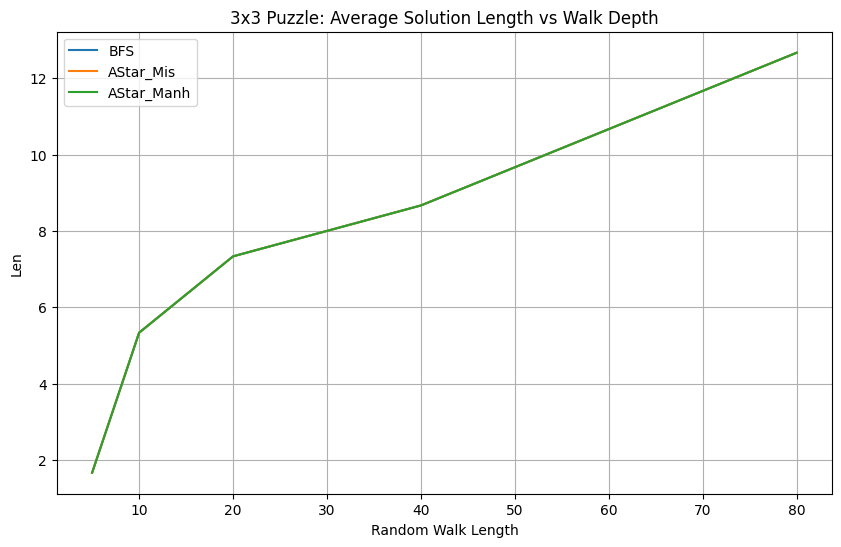

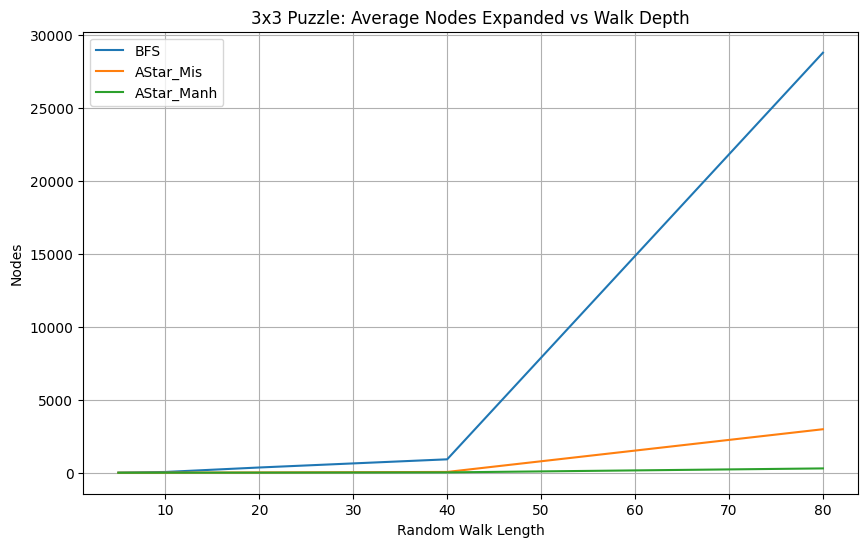

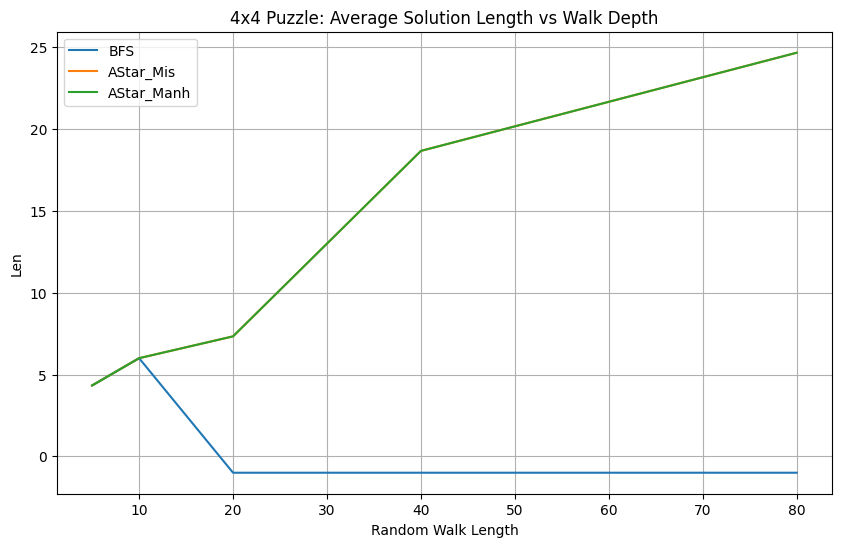

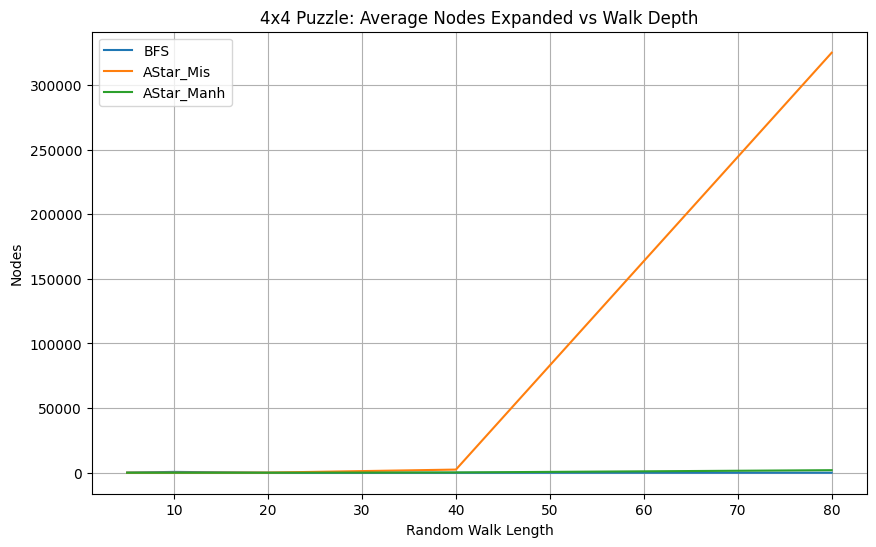

In [1]:
# 15 Puzzle Search Comparison Notebook

import random
import heapq
import time
import sys
from collections import deque, defaultdict
import pandas as pd
import matplotlib.pyplot as plt

sys.setrecursionlimit(10000)  # Increase recursion depth safely

# --- Utility Functions ---

def print_puzzle(state, size):
    for i in range(0, size * size, size):
        print(" ".join(f"{x:2}" if x != 0 else "  " for x in state[i:i + size]))
    print()

def puzzle_to_str(state):
    return "".join(map(str, state))

def get_goal_state(size):
    return list(range(1, size*size)) + [0]

# --- Successor Function ---

def get_successors(state, size):
    idx = state.index(0)
    row, col = divmod(idx, size)
    moves = []
    directions = [(-1,0), (1,0), (0,-1), (0,1)]
    for dr, dc in directions:
        r, c = row + dr, col + dc
        if 0 <= r < size and 0 <= c < size:
            new_idx = r * size + c
            new_state = state[:]
            new_state[idx], new_state[new_idx] = new_state[new_idx], new_state[idx]
            moves.append(new_state)
    return moves

# --- Heuristics ---

def misplaced_tiles(state, goal):
    return sum(1 for i in range(len(state)) if state[i] != 0 and state[i] != goal[i])

def manhattan_distance(state, goal, size):
    distance = 0
    for i, tile in enumerate(state):
        if tile != 0:
            goal_idx = goal.index(tile)
            x1, y1 = divmod(i, size)
            x2, y2 = divmod(goal_idx, size)
            distance += abs(x1 - x2) + abs(y1 - y2)
    return distance

# --- Random Walk ---

def random_walk(state, steps, size):
    current = state[:]
    for _ in range(steps):
        successors = get_successors(current, size)
        current = random.choice(successors)
    return current

# --- BFS ---

def bfs(start, goal, size, max_depth=50_000):
    frontier = deque([(start, [])])
    explored = set()
    nodes_expanded = 0
    while frontier:
        state, path = frontier.popleft()
        if state == goal:
            return path, nodes_expanded
        explored.add(tuple(state))
        if len(path) > max_depth:
            break
        for succ in get_successors(state, size):
            if tuple(succ) not in explored:
                frontier.append((succ, path + [succ]))
                explored.add(tuple(succ))
        nodes_expanded += 1
    return None, nodes_expanded

# --- A* ---

def astar(start, goal, size, heuristic, max_depth=50_000):
    frontier = []
    heapq.heappush(frontier, (heuristic(start, goal), 0, start, []))
    explored = set()
    nodes_expanded = 0
    while frontier:
        est_total, cost, state, path = heapq.heappop(frontier)
        if state == goal:
            return path, nodes_expanded
        explored.add(tuple(state))
        if len(path) > max_depth:
            break
        for succ in get_successors(state, size):
            if tuple(succ) not in explored:
                new_cost = cost + 1
                h = heuristic(succ, goal)
                heapq.heappush(frontier, (new_cost + h, new_cost, succ, path + [succ]))
        nodes_expanded += 1
    return None, nodes_expanded

# --- Run Experiments ---
def run_experiment(size, walk_lengths):
    goal = get_goal_state(size)
    results = []
    for steps in walk_lengths:
        for i in range(3):
            start = random_walk(goal, steps, size)
            print(f"--- {size}x{size} Puzzle, Walk Length: {steps}, Problem #{i+1} ---")
            print("Start State:")
            print_puzzle(start, size)

            try:
                if size == 3 or steps <= 10:
                    bfs_path, bfs_nodes = bfs(start, goal, size)
                else:
                    bfs_path, bfs_nodes = None, -3
            except (MemoryError, RecursionError):
                bfs_path, bfs_nodes = None, -1

            try:
                a_star_mis_path, mis_nodes = astar(start, goal, size, misplaced_tiles)
            except (MemoryError, RecursionError):
                a_star_mis_path, mis_nodes = None, -1

            try:
                a_star_manh_path, manh_nodes = astar(start, goal, size, lambda s, g: manhattan_distance(s, g, size))
            except (MemoryError, RecursionError):
                a_star_manh_path, manh_nodes = None, -1

            def display_result(label, path, nodes):
                print(f"{label} Solution:")
                if path is None:
                    print("  No solution found.")
                else:
                    print(f"  Steps: {len(path)}")
                    print(f"  Nodes Expanded: {nodes}")
                print()

            display_result("BFS", bfs_path, bfs_nodes)
            display_result("A* Misplaced Tiles", a_star_mis_path, mis_nodes)
            display_result("A* Manhattan", a_star_manh_path, manh_nodes)

            results.append({
                "Size": f"{size}x{size}",
                "WalkSteps": steps,
                "StartState": puzzle_to_str(start),
                "BFS_Len": len(bfs_path) if bfs_path else -1,
                "BFS_Nodes": bfs_nodes,
                "AStar_Mis_Len": len(a_star_mis_path) if a_star_mis_path else -1,
                "AStar_Mis_Nodes": mis_nodes,
                "AStar_Manh_Len": len(a_star_manh_path) if a_star_manh_path else -1,
                "AStar_Manh_Nodes": manh_nodes
            })
    return results

# --- Execute All Experiments ---
walks = [5, 10, 20, 40, 80]
results_3x3 = run_experiment(3, walks)
results_4x4 = run_experiment(4, walks)

# --- Create DataFrame ---
df_3x3 = pd.DataFrame(results_3x3)
df_4x4 = pd.DataFrame(results_4x4)

# --- Save Results ---
df_3x3.to_csv("3x3_results.csv", index=False)
df_4x4.to_csv("4x4_results.csv", index=False)

# --- Plotting ---
def plot_metric(df, metric, title):
    plt.figure(figsize=(10,6))
    for alg in ["BFS", "AStar_Mis", "AStar_Manh"]:
        subset = df[["WalkSteps", f"{alg}_{metric}" ]].copy()
        grouped = subset.groupby("WalkSteps").mean()
        plt.plot(grouped.index, grouped[f"{alg}_{metric}"], label=alg)
    plt.title(title)
    plt.xlabel("Random Walk Length")
    plt.ylabel(metric.replace("_", " "))
    plt.legend()
    plt.grid(True)
    plt.show()

plot_metric(df_3x3, "Len", "3x3 Puzzle: Average Solution Length vs Walk Depth")
plot_metric(df_3x3, "Nodes", "3x3 Puzzle: Average Nodes Expanded vs Walk Depth")
plot_metric(df_4x4, "Len", "4x4 Puzzle: Average Solution Length vs Walk Depth")
plot_metric(df_4x4, "Nodes", "4x4 Puzzle: Average Nodes Expanded vs Walk Depth")


# --- Summary ---
"""
### Search Performance Summary

1. Exponential Growth with Problem Size
Moving from the 3x3 (8-puzzle) to the 4x4 (15-puzzle) explodes the state space:

8-puzzle has 9! = 362,880 possible states.

15-puzzle has 16! ≈ 2.1 × 10¹³ states.

BFS cannot handle this exponential blowup beyond shallow depths. Even A* struggles without strong heuristics.

2. Heuristics Are Crucial
A* with Manhattan Distance far outperforms BFS and A* with Misplaced Tiles:

Fewer nodes expanded.

Faster convergence.

More scalability.

This shows that search efficiency in AI heavily depends on the quality of the heuristic used.

3. Trade-Off Between Optimality and Feasibility
BFS is optimal (if it completes), but infeasible on large problems.

A* is also optimal with admissible heuristics, and it's far more feasible when using informed guidance like Manhattan Distance.

Real-world AI often favors informed, approximate, or heuristic-based search for scalability.

4. Search Reflects Broader AI Challenges
This puzzle serves as a microcosm of real AI tasks: planning, robotics, and game solving.

It underscores how AI often deal with:

Huge state spaces

Limited computational resources

Need for intelligent approximation

"""
